# Titanic Survival Probabilities- rough copy 
-----
### This notebook aims to calculate the metrics of survival probabilities for the passengers on the Titanic voyage. We will look at the effect of sex/gender, class, age and port of embarkment on each individuals chance of survival. 

#### First, I will calculate the survival probability of each metric 'by hand', and display various graphs for visualizing the data. Then I will create my own surivial probability function using the 'by hand' calculations that I will use to compare to a Machine Learning (ML) algorithm to see if we get the same answers. 

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt #matlab plots

#useful packages for math, statistics and dictionaries 
from scipy import stats 
#import statistics as sts
#from scipy.optimize import curve_fit as cf 
import numpy as np  
import collections #ordered dictionary

#importing,cleaning and managing datasets 
import pandas as pd 
from pandas import Series,DataFrame

import seaborn as sns 
sns.set_style('whitegrid') # style preference on graphs
# from the tutorial for machine learning 

# for generating random seeds in the game 
from random import seed
from random import random
# seed random number generator
seed(1)

#import sklearn
#from time import time 
#from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.model_selection import train_test_split
#from sklearn import tree 
#from decimal import * 

test_data = pd.read_csv('data/titanic_test.csv')
train_data = pd.read_csv('data/titanic_train.csv')

print(test_data.info(), test_data.head(), sep='\n')
print(train_data.info(), train_data.head(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                   

### Functions that I will use: 

In [3]:
# definitions and functions section 

# clean the loaded titanic databases 
def tidy_the_data(df): 
    
    #convert male/female into 0's/1's 
    df.loc[ df["Sex"] == "male", "Sex"] = int(0)
    df.loc[ df["Sex"] == "female" , "Sex"] = int(1)
    
    # fill embarked values and assign s,c,q = 0,1,2 
    df['Embarked'] = df["Embarked"].fillna('S')
    df.loc[df['Embarked'] == 'S', 'Embarked'] = int(0) 
    df.loc[df['Embarked'] == 'C', 'Embarked'] = int(1)
    df.loc[df['Embarked'] == 'Q', 'Embarked'] = int(2) 
    
    return df 

#fill ordered dictionary
def make_Ord_dic(pd_data, dic):
    nan_count = 0
    for x in range(len(pd_data)): 
        age = pd_data.loc[x,"Age"]
        if np.isnan(age): 
            nan_count +=1
        else: 
            if int(age) not in dic: 
                dic[int(age)] = [0,0]
            if pd_data.loc[x,"Survived"] == 0: #died
                dic[int(age)][0] +=1
            else:# survived
                dic[int(age)][1] +=1
    
    dic = collections.OrderedDict(sorted(dic.items()))
    return dic, nan_count

# fill test dictionary 
def make_test_dic(pd_data, dic): 
    nan_count = 0 
    for x in range(len(pd_data)): 
        age = pd_data.loc[x,'Age']
        if np.isnan(age): 
            nan_count +=1
        else: 
            if int(age) not in dic: 
                dic[int(age)] = 0
            dic[int(age)] +=1
    dic = collections.OrderedDict(sorted(dic.items()))
    return dic, nan_count

In [ ]:
%%javascript
Jupyter.notebook.execute_cells([6])

In [4]:
# know from the working directory that the data needs cleaning, so clean it up and drop unnecessary columns 

# cleaning data
tidy_the_data(test_data)
tidy_the_data(train_data)

# drop the 'useless' columns 
test_data = test_data.drop(['Cabin','Fare','Ticket'], axis=1)
train_data = train_data.drop(['Cabin','Fare','Ticket'], axis=1)

print('-----------------Test information----------------')
print(test_data.head())
print('-----------------Train information----------------')
print(train_data.head())


-----------------Test information----------------
   PassengerId  Pclass                                          Name Sex  \
0          892       3                              Kelly, Mr. James   0   
1          893       3              Wilkes, Mrs. James (Ellen Needs)   1   
2          894       2                     Myles, Mr. Thomas Francis   0   
3          895       3                              Wirz, Mr. Albert   0   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   1   

    Age  SibSp  Parch Embarked  
0  34.5      0      0        2  
1  47.0      1      0        0  
2  62.0      0      0        2  
3  27.0      0      0        0  
4  22.0      1      1        0  
-----------------Train information----------------
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                           

<IPython.core.display.Javascript object>


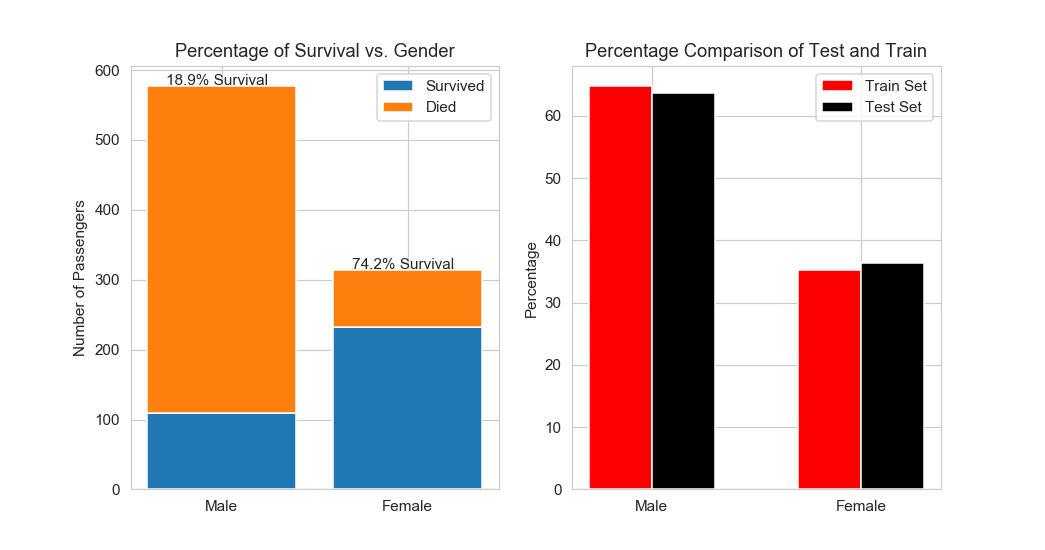

In [4]:
# Look at the breakdown of survival by gender 

# male counts, more males died so acending = False gives index 0=dead, 1=survived 
male_counts = np.array(train_data["Survived"][train_data["Sex"] == 0].value_counts().sort_index())

#female counts, more females survived so ascending = True gives index 0=dead, 1=survived
female_counts = np.array(train_data["Survived"][train_data["Sex"] == 1].value_counts().sort_index())

total_counts = np.vstack([male_counts, female_counts])

# 
counts_test = np.array(test_data["Sex"].value_counts().sort_index()) 
percentage = np.array([[sum(total_counts[0,:])*100/len(train_data), sum(total_counts[1,:])*100/len(train_data)] ,\
                       [counts_test[0]*100/len(test_data), counts_test[1]*100/len(test_data)]])

# get the survival percentage for each gender 
surv_gender = [male_counts[1]/sum(male_counts)*100, female_counts[1]/sum(female_counts)*100]

# plot the values 
fig0 = plt.figure(figsize=(9.5,5))
ax= fig0.add_subplot(121)

x = np.array([0,1])
plt.bar(x, total_counts[:,1], align='center', label="Survived")
plt.bar(x, total_counts[:,0], align='center', bottom=total_counts[:,1], label="Died")

plt.xticks(x, ['Male', 'Female'])
plt.legend()
plt.ylabel("Number of Passengers")
plt.title("Percentage of Survival vs. Gender")

j = 1
# set individual bar lables using above list of survival percentage
for i in ax.patches:
    if (j >= 3): #male 
        ax.text(i.get_x()+0.1,i.get_height()+ i.get_y()+1, str(round(surv_gender[j-3],1))+'% Survival' ) 
    j+=1

ax= fig0.add_subplot(122)    
width = 0.3 
plt.bar(x, percentage[0,:], width, label="Train Set", color='r')
plt.bar(x+width, percentage[1,:], width, label="Test Set", color='k')

plt.xticks(x+width/2, ['Male', 'Female'])
plt.ylabel("Percentage")
plt.title("Percentage Comparison of Test and Train")
plt.legend()

plt.show()

{'First': [80, 136], 'Second': [97, 87], 'Third': [372, 119]}
[25.59808612 22.24880383 52.15311005]
[24.242424242424242, 20.650953984287316, 55.10662177328844]


<IPython.core.display.Javascript object>


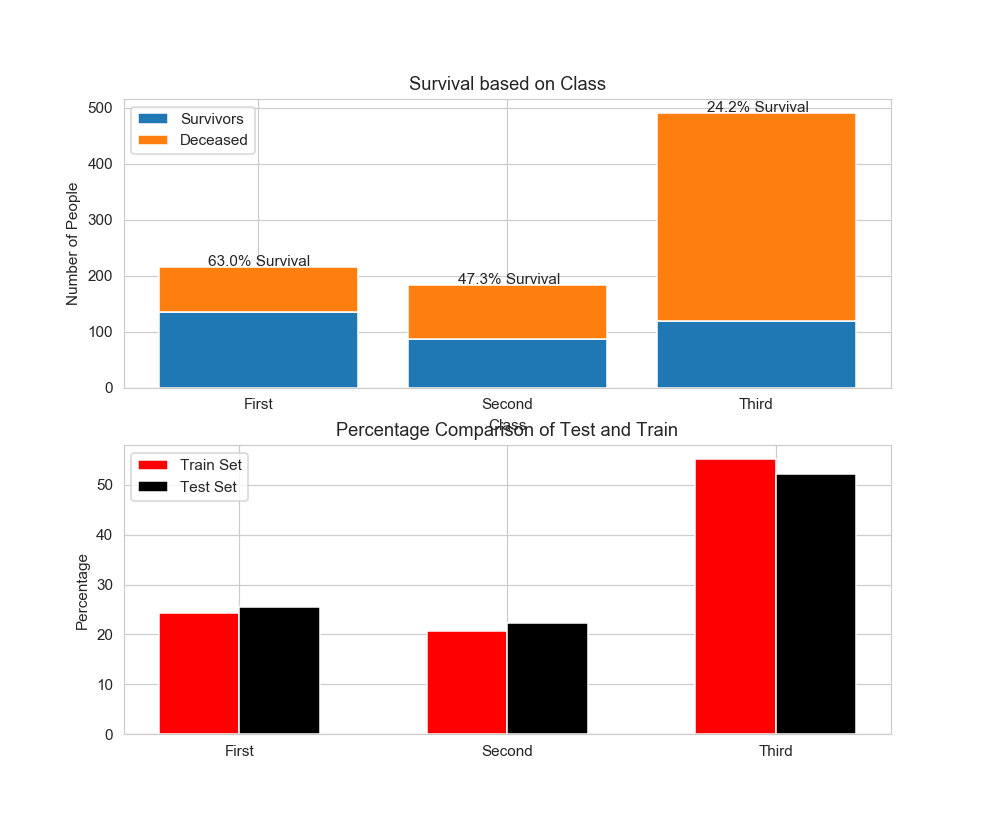

891
418


In [55]:
# breakdown of survival by class 

dic_class ={}
dic_class['First'] = list(train_data["Survived"][train_data["Pclass"] == 1].value_counts().sort_index())
dic_class['Second'] = list(train_data["Survived"][train_data["Pclass"] == 2].value_counts().sort_index())
dic_class['Third'] = list(train_data["Survived"][train_data["Pclass"] == 3].value_counts().sort_index())

print(dic_class)

# breakdown of percentage of test set 
class_test = np.array(test_data["Pclass"].value_counts().sort_index())
class_test_per = np.array([ class_test[0]*100/len(test_data), class_test[1]*100/len(test_data), \
                           class_test[2]*100/len(test_data) ])
print(class_test_per)
#create a list of the survival and total percentages
surv_class = []
class_total = []
for y in dic_class.keys(): 
    surv_class.append( dic_class[y][1]/sum(dic_class[y])*100 )
    class_total.append(sum(dic_class[y])*100/len(train_data) )

print(class_total)

# plot the figure change to 5 
fig1 = plt.figure(figsize=(9,7.5))
ax= fig1.add_subplot(211)

# plot data stacked 
plt.bar(dic_class.keys(), np.array(list(dic_class.values()))[:,1], width=0.8, label='Survivors')
plt.bar(dic_class.keys(), np.array(list(dic_class.values()))[:,0], width=0.8, label='Deceased', \
        bottom= np.array(list(dic_class.values()))[:,1])

plt.legend(loc='best')
plt.title("Survival based on Class")
plt.xlabel("Class")
plt.ylabel("Number of People")

j = 1
# set individual bar lables using above list of survival percentage
for i in ax.patches:
    if (j >= 4): 
        ax.text(i.get_x()+0.2,i.get_height()+ i.get_y()+1, str(round(surv_class[j-4],1))+'% Survival' ) 
    j+=1
    
ax= fig1.add_subplot(212)    
width = 0.3 
x = np.array([1,2,3])
plt.bar(x, class_total, width, label="Train Set", color='r')
plt.bar(x+width, class_test_per, width, label="Test Set", color='k')

plt.xticks(x+width/2, dic_class.keys())
plt.ylabel("Percentage")
plt.title("Percentage Comparison of Test and Train")
plt.legend()

plt.show()
print(len(train_data))
print(len(test_data))

In [ ]:
print(train_data["Survived"][train_data["Embarked"] == 0]\
                                        .value_counts().sort_index())
print(train_data["Survived"][train_data["Embarked"] == 1].value_counts().sort_index())


[64.59330144 24.40191388 11.00478469]
[72.50280583613917, 18.855218855218855, 8.641975308641975]


<IPython.core.display.Javascript object>


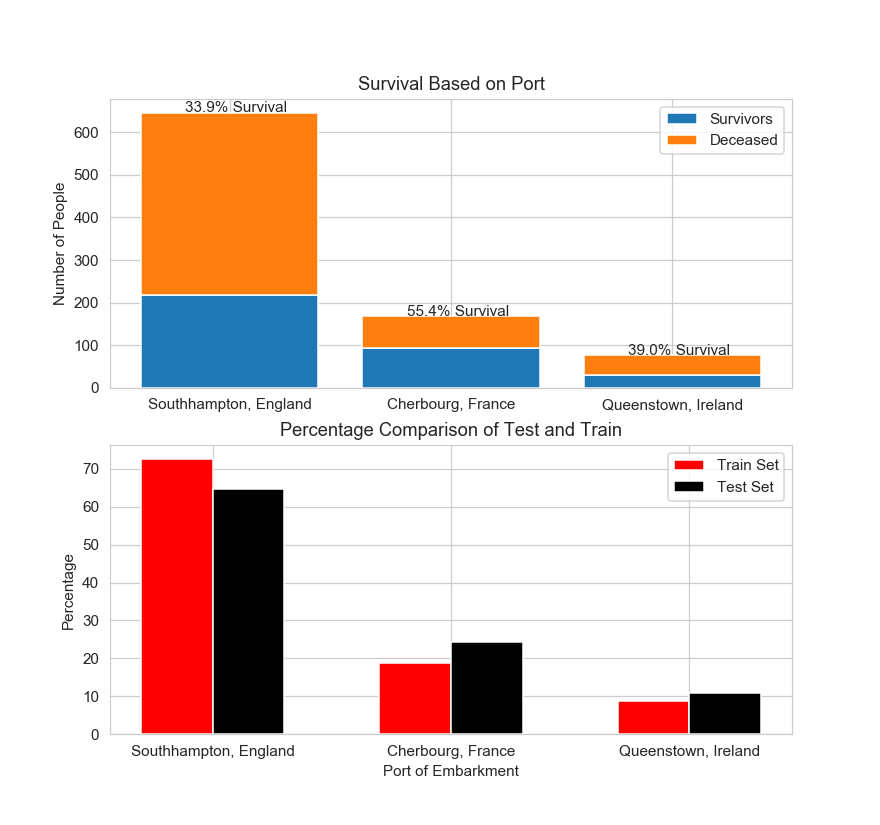

In [54]:
# breakdown of survival by port of embarkment (we are assuming that this can be analgous to nationality)

port_dic = {}
port_dic['Southhampton, England']= list(train_data["Survived"][train_data["Embarked"] == 0]\
                                        .value_counts().sort_index())
port_dic['Cherbourg, France']= list(train_data["Survived"][train_data["Embarked"] == 1]\
                                    .value_counts().sort_index())
port_dic['Queenstown, Ireland']= list(train_data["Survived"][train_data["Embarked"] == 2]\
                                      .value_counts().sort_index())

port_test = np.array(test_data["Embarked"].value_counts().sort_index())
port_test_per = np.array([port_test[0]*100/len(test_data), port_test[1]*100/len(test_data),
                          port_test[2]*100/len(test_data) ])
print(port_test_per)

surv_port = [] 
port_total = []
for y in port_dic.keys(): 
    surv_port.append(port_dic[y][1]/sum(port_dic[y])*100)
    port_total.append(sum(port_dic[y])*100/len(train_data))

print(port_total)

fig2 = plt.figure(figsize=(8,7.5))
ax= fig2.add_subplot(211)

# (column number, value, alignment over the column, bottom = anything under it) survivors
plt.bar(port_dic.keys(), np.array(list(port_dic.values()))[:,1], align='center', label='Survivors')
# top values: deaths 
plt.bar(port_dic.keys(), np.array(list(port_dic.values()))[:,0], \
        align='center', bottom=np.array(list(port_dic.values()))[:,1],label='Deceased' )

plt.legend(loc='best')
plt.title("Survival Based on Port")
plt.ylabel("Number of People")

j = 1
# set individual bar lables using above list of survival percentage
for i in ax.patches:
    if (j >= 4): 
        ax.text(i.get_x()+0.2,i.get_height()+ i.get_y()+1, str(round(surv_port[j-4], 1))+'% Survival' ) 
    j+=1

ax= fig2.add_subplot(212)   
width = 0.3 
x = np.array([1,2,3])
plt.bar(x, port_total, width, label="Train Set", color='r')
plt.bar(x+width, port_test_per, width, label="Test Set", color='k')

plt.xticks(x+width/2, port_dic.keys())
plt.ylabel("Percentage")
plt.title("Percentage Comparison of Test and Train")
plt.xlabel("Port of Embarkment")
plt.legend()
plt.show()

OrderedDict([(0, 5), (1, 3), (2, 2), (3, 1), (5, 1), (6, 3), (7, 1), (8, 2), (9, 2), (10, 2), (11, 1), (12, 2), (13, 3), (14, 3), (15, 1), (16, 2), (17, 7), (18, 16), (19, 4), (20, 8), (21, 17), (22, 17), (23, 11), (24, 17), (25, 11), (26, 13), (27, 12), (28, 8), (29, 10), (30, 15), (31, 6), (32, 8), (33, 6), (34, 2), (35, 5), (36, 10), (37, 3), (38, 4), (39, 6), (40, 6), (41, 5), (42, 5), (43, 4), (44, 1), (45, 9), (46, 3), (47, 5), (48, 5), (49, 3), (50, 5), (51, 1), (53, 3), (54, 2), (55, 6), (57, 3), (58, 1), (59, 1), (60, 4), (61, 2), (62, 1), (63, 2), (64, 3), (67, 1), (76, 1)])
86


<IPython.core.display.Javascript object>


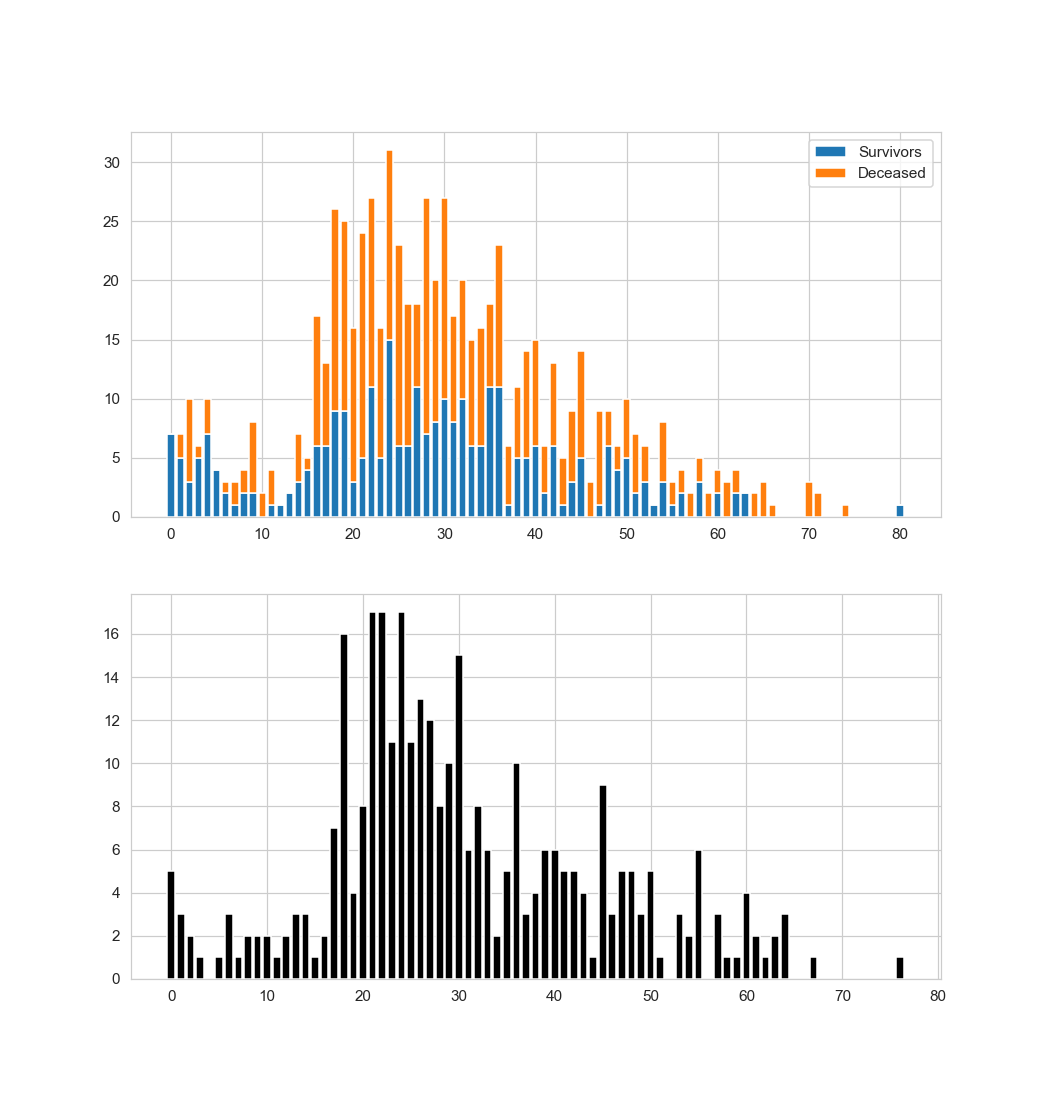

In [7]:
# breakdown of survival by age 
#create an empty dictionary 
order_dic = collections.OrderedDict()
test_dic = collections.OrderedDict() 

# fill nan's in age with median (for now)
#train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

# fill the ordered dictionary with [died, survivor] counts 
order_dic, na_num = make_Ord_dic(train_data, order_dic)

test_dic, na_test = make_test_dic(test_data, test_dic)
print(test_dic)
print(na_test)

fig3 = plt.figure(figsize=(9.5,10))
ax= fig3.add_subplot(211)

# (column number, value, alignment over the column, bottom = anything under it) survivors
plt.bar(order_dic.keys(), np.array(list(order_dic.values()))[:,1], align='center', label='Survivors')
# top values: deaths 
plt.bar(order_dic.keys(), np.array(list(order_dic.values()))[:,0], \
        align='center', bottom=np.array(list(order_dic.values()))[:,1],label='Deceased' )

plt.legend(loc='best')

ax= fig3.add_subplot(212)
plt.bar(test_dic.keys(), np.array(list(test_dic.values())), align='center', color='k')

plt.show()

OrderedDict([(0, 100.0), (1, 71.42857142857143), (2, 30.0), (3, 83.33333333333334), (4, 70.0), (5, 100.0), (6, 66.66666666666666), (7, 33.33333333333333), (8, 50.0), (9, 25.0), (10, 0.0), (11, 25.0), (12, 100.0), (13, 100.0), (14, 42.857142857142854), (15, 80.0), (16, 35.294117647058826), (17, 46.15384615384615), (18, 34.61538461538461), (19, 36.0), (20, 18.75), (21, 20.833333333333336), (22, 40.74074074074074), (23, 31.25), (24, 48.38709677419355), (25, 26.08695652173913), (26, 33.33333333333333), (27, 61.111111111111114), (28, 25.925925925925924), (29, 40.0), (30, 37.03703703703704), (31, 47.05882352941176), (32, 50.0), (33, 40.0), (34, 37.5), (35, 61.111111111111114), (36, 47.82608695652174), (37, 16.666666666666664), (38, 45.45454545454545), (39, 35.714285714285715), (40, 40.0), (41, 33.33333333333333), (42, 46.15384615384615), (43, 20.0), (44, 33.33333333333333), (45, 35.714285714285715), (46, 0.0), (47, 11.11111111111111), (48, 66.66666666666666), (49, 66.66666666666666), (50, 50

<IPython.core.display.Javascript object>


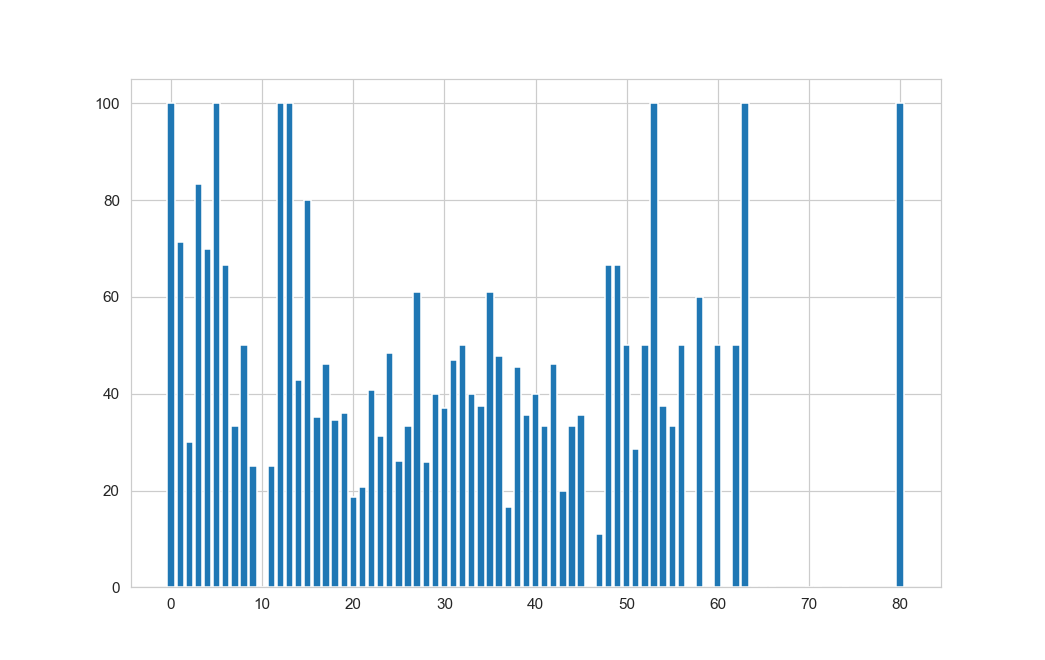

In [8]:
# survival percentage by age based on the above breakdown 

def age_surv(dic_old, dic_new):
    for key,value in dic_old.items():
        #if sum(value)>= 5: 
        dic_new[key] = value[1]/sum(value)*100
       # else: # not enough statistics set to titanic average 31.74
        #    dic_new[key] = 31.74
    return dic_new

surv_age = collections.OrderedDict()
surv_age = age_surv(order_dic, surv_age)
print(surv_age)

fig4 = plt.figure(figsize=(9.5,6))
ax= fig4.add_subplot(111)

plt.bar(surv_age.keys(), surv_age.values(), align='center', label='Survival Percentage')

plt.show()

147 418


<IPython.core.display.Javascript object>


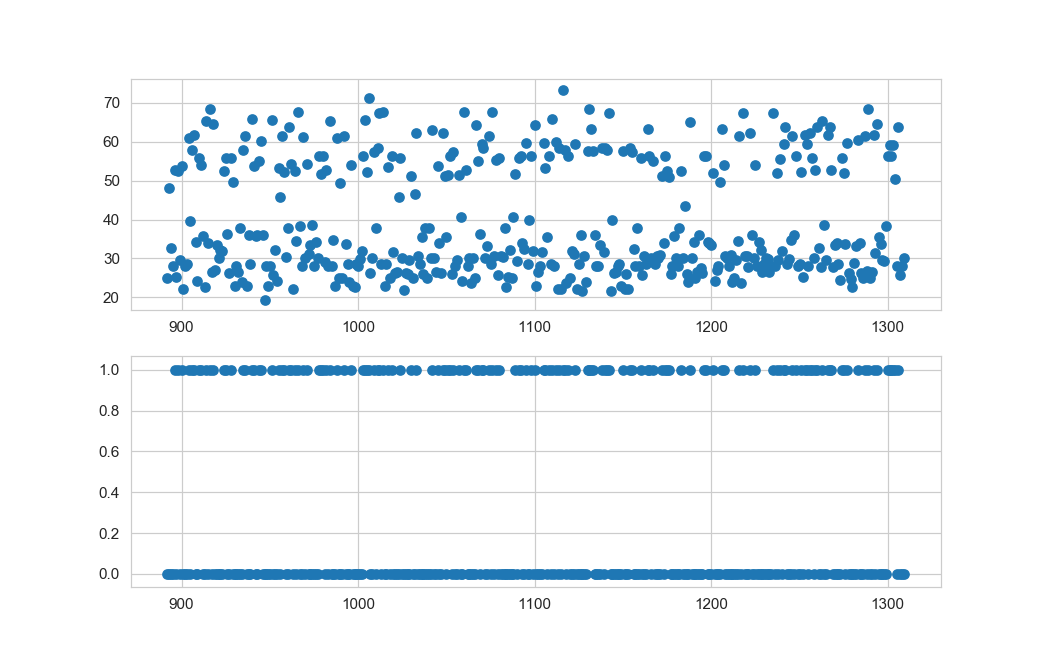

In [9]:
# lets build the function that will calculate the survival percentage of the train_data set 
def will_they_survive(data_set,tolerance,weights): 
    survive_byHand = []
    guess_array = []
    count = 0
    for x in range(len(data_set)): 
        sex_pcnt = surv_gender[data_set.loc[x,"Sex"]]
        class_pcnt = surv_class[data_set.loc[x,"Pclass"]-1]
        board_pcnt = surv_port[data_set.loc[x,"Embarked"]]
        
        p_age =  data_set.loc[x,'Age']        
        if int(p_age) not in surv_age: 
            # survival fraction of titanic in total 
            age_pcnt = 31.74
        else: 
            age_pcnt = surv_age[int(p_age)]
    
        total_pcnt = (sex_pcnt/100*weights[0] + class_pcnt/100*weights[1]\
                        + age_pcnt/100*weights[2] + board_pcnt/100*weights[3])*100
        if total_pcnt >=tolerance: #62.6424 : 
            guess = 1
            count += 1
        else: 
            guess = 0
        guess_array.append(guess)
        survive_byHand.append([data_set.loc[x,"PassengerId"], total_pcnt])
    return np.array(survive_byHand, dtype='object'),guess_array, count
        
test_data["Age"] = test_data["Age"].fillna(test_data['Age'].median())
#print(surv_gender)
#print(surv_class)
#print(surv_port)
#print(surv_age)
bh_pcnt, bh_guess, num_surv = will_they_survive(test_data,50,[.5,.25,.15,.10])  
print(num_surv, len(bh_guess))

fig4 = plt.figure(figsize=(9.5,6))
ax= fig4.add_subplot(211)

plt.scatter(bh_pcnt[:,0], bh_pcnt[:,1])

ax= fig4.add_subplot(212)
plt.scatter(bh_pcnt[:,0], bh_guess[:])

plt.show()


In [77]:

train_total_survival = np.array(train_data["Survived"].value_counts().sort_index())
print(train_total_survival)
print(train_total_survival[1]/sum(train_total_survival)*100)
print(train_total_survival[0]/sum(train_total_survival)*100)

[549 342]
38.38383838383838
61.61616161616161


# Machine Learning Algorithms

### I will use a decision tree and a random forest regressor to predict which passengers survive from the test_data set. This will allow 3 independent methods of calculating the survial of the passengers from the test set of data. 

In [6]:
# Decision Tree 
from sklearn import tree, model_selection

# cant have nan's so fill age data for now... will come up with more accurate method soon 
median = train_data['Age'].median()
train_data['Age'] = train_data['Age'].fillna(median)

# set up training values and perdiction values 
surv_outcome = train_data['Survived'].values
training_features = train_data[['Pclass', 'Age', 'Sex', 'Embarked']].values
print(training_features)

#making decision tree, max depth the tree should go to (to correct overfitting use <= # features), random_state to 
#   control the random number generator used (0/42 common),min_samples_split = number of samples required 
#   to split a node
dt = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=2, random_state= 42)

# train tree 
fit_dt = dt.fit(training_features, surv_outcome)

# look at the outcomes! 
# order of importance 
print('importance (%): [class, age, sex, port]', fit_dt.feature_importances_*100)
# r^2 of fit
dt_r2 = fit_dt.score(training_features, surv_outcome)
print('r^2 value:', dt_r2)
print(" ")

#lets see how accurate our r^2 values is by getting the mean of the scores
dt_scores = model_selection.cross_val_score(fit_dt, training_features, surv_outcome, scoring='accuracy', cv=10)
print("all r^2's:", dt_scores)
print('average r^2: ',dt_scores.mean())
print('difference r^2 - aver^2', dt_r2 - dt_scores.mean())

[[3 22.0 0 0]
 [1 38.0 1 1]
 [3 26.0 1 0]
 ...
 [3 28.0 1 0]
 [1 26.0 0 1]
 [3 32.0 0 2]]
importance (%): [class, age, sex, port] [23.47689803 10.88621802 61.70498028  3.93190367]
r^2 value: 0.8282828282828283
 
all r^2's: [0.78888889 0.80898876 0.78651685 0.87640449 0.87640449 0.79775281
 0.79775281 0.76404494 0.84269663 0.84269663]
average r^2:  0.818214731585518
difference r^2 - aver^2 0.010068096697310236


In [7]:
# with the decision tree in place, lets run it on the test data 

# fill nan's on the test set 
test_med = test_data['Age'].median()
test_data["Age"] = test_data["Age"].fillna(test_med)

# predition values 
test_features = test_data[['Pclass', 'Age', 'Sex', 'Embarked']].values 

# random forest (rf) prediction
dt_survival = fit_dt.predict(test_features)

# lets look: 
survived_dt = np.count_nonzero(dt_survival)
died_dt = len(dt_survival)- np.count_nonzero(dt_survival)
print('total number of predictions', len(dt_survival))
print('number of survivors:', survived_dt)
print('Number of fatalities:', died_dt)
print('death rate (%)', died_dt/len(dt_survival)*100 )

#can we get a percentage for each of the predictions? 
dt_percent = fit_dt.predict_proba(test_features)

print('precent of [died (0), live (1)]', dt_percent[0:10,:], sep='\n')
print(type(dt_percent))
print(dt_survival[0:10])


total number of predictions 418
number of survivors: 107
Number of fatalities: 311
death rate (%) 74.4019138755981
precent of [died (0), live (1)]
[[0.89073634 0.10926366]
 [0.9        0.1       ]
 [0.89073634 0.10926366]
 [0.89073634 0.10926366]
 [0.58974359 0.41025641]
 [0.89073634 0.10926366]
 [1.         0.        ]
 [0.89073634 0.10926366]
 [0.25       0.75      ]
 [0.89073634 0.10926366]]
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 1 0]


In [8]:
# the random forest regressor 
from sklearn import ensemble, model_selection 

# cant have nan's so fill age data for now... will come up with more accurate method soon 
median = train_data['Age'].median()
train_data['Age'] = train_data['Age'].fillna(median)

#set up the values we want the ML to use to predict and the values we want predicted
surv_outcome = train_data['Survived'].values
training_features = train_data[['Pclass', 'Age', 'Sex', 'Embarked']].values

#make the random forest: number of trees = 100, max_depth <= num of features, number of samples required 
#to split a node = 2, random_state to control the random number generator used (0/42 common),
# n_jobs of -1 means using all processors
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth = 4, min_samples_split= 2, \
                                     random_state = 42, n_jobs = -1)

# fit forest 
fit_rf = rf.fit(training_features, surv_outcome)

# look at outcomes 
# order of importance 
print('importance (%): [class, age, sex, port]', fit_rf.feature_importances_*100)
# r^2 of fit
r2 = fit_rf.score(training_features, surv_outcome)
print('r^2 value:', r2)
print(" ")
#lets see how accurate our r^2 values is by getting the mean of the scores 
the_scores = model_selection.cross_val_score(fit_rf, training_features, surv_outcome, scoring='accuracy', cv=10)
print("all r^2's:", the_scores)
print('average r^2: ',the_scores.mean())
print('difference r^2 - aver^2', r2 -the_scores.mean())
print('these match quite well so its unlikely we are overfitting the data')


importance (%): [class, age, sex, port] [22.91846376 13.95172661 58.77647032  4.35333931]
r^2 value: 0.835016835016835
 
all r^2's: [0.83333333 0.79775281 0.78651685 0.87640449 0.86516854 0.80898876
 0.82022472 0.75280899 0.85393258 0.83146067]
average r^2:  0.8226591760299625
difference r^2 - aver^2 0.012357658986872466
these match quite well so its unlikely we are overfitting the data


In [9]:
# now that we have a trained forest, time to run it on the test_data 
print(max(test_data['Age']))
print(min(test_data["Age"]))
# fill nan's 
test_med = test_data['Age'].median()
test_data["Age"] = test_data["Age"].fillna(test_med)

# predition values 
test_features = test_data[['Pclass', 'Age', 'Sex', 'Embarked']].values 
print(test_features)
# random forest (rf) prediction
rf_survival = fit_rf.predict(test_features)

# lets look: 
survived_rf = np.count_nonzero(rf_survival)
died_rf = len(rf_survival)- np.count_nonzero(rf_survival)
print('total number of predictions:', len(rf_survival))
print('number of survivors:', survived_rf)
print('Number of fatalities:', died_rf)
print('death rate (%)', died_rf/len(rf_survival)*100 )

#can we get a percentage for each of the predictions? 
rf_percent = fit_rf.predict_proba(test_features)

print(' [died (0), live (1)] fraction', rf_percent[0:10,:], sep='\n')
print(rf_survival[0:10])

76.0
0.17
[[3 34.5 0 2]
 [3 47.0 1 0]
 [2 62.0 0 2]
 ...
 [3 38.5 0 0]
 [3 27.0 0 0]
 [3 27.0 0 1]]
total number of predictions: 418
number of survivors: 115
Number of fatalities: 303
death rate (%) 72.48803827751196
 [died (0), live (1)] fraction
[[0.88327179 0.11672821]
 [0.72566018 0.27433982]
 [0.86885099 0.13114901]
 [0.86830811 0.13169189]
 [0.57044567 0.42955433]
 [0.86986898 0.13013102]
 [0.47313195 0.52686805]
 [0.8566871  0.1433129 ]
 [0.37549412 0.62450588]
 [0.87962189 0.12037811]]
[0 0 0 0 0 0 1 0 1 0]


46


<IPython.core.display.Javascript object>


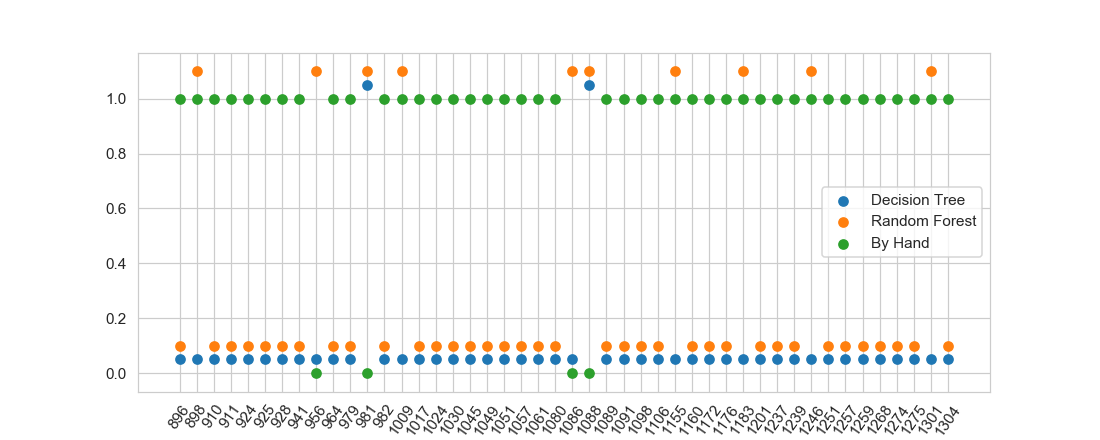

In [14]:
# lets visualize the results 
# lets look specifically at the people where the two methods predicted differences 

# find the indexes that are different and put them in an array with their corresponding dt and rf values
graph_array = [] 
diff_index = [] # used below 
for x in range(len(dt_survival)):
   # print(test_data.loc[x, "PassengerId"], dt_survival[x], rf_survival[x], bh_guess[x])
    if (rf_survival[x] != bh_guess[x]):
        diff_index.append(x) # will use this to look at percentages
        graph_array.append([test_data.loc[x, "PassengerId"], dt_survival[x], rf_survival[x], bh_guess[x]]) 
    elif (dt_survival[x] != bh_guess[x]): 
        diff_index.append(x) # will use this to look at percentages
        graph_array.append([test_data.loc[x, "PassengerId"], dt_survival[x], rf_survival[x], bh_guess[x]]) 
    elif (dt_survival[x] != rf_survival[x]) : 
        diff_index.append(x) # will use this to look at percentages
        graph_array.append([test_data.loc[x, "PassengerId"], dt_survival[x], rf_survival[x], bh_guess[x]]) 
    else: 
        continue
        
graph_array = np.array(graph_array)
#print(graph_array)
print(len(graph_array))
N = np.arange(len(graph_array))
fig10 = plt.figure(figsize=(10,4))
ax = fig10.add_subplot(111)

# plot scatter with PassengerId as x and dt_/rf_ survival as y 
plt.scatter(N, graph_array[:,1]+.05, label="Decision Tree")
plt.scatter(N, graph_array[:,2]+0.1, label ="Random Forest")
plt.scatter(N, graph_array[:,3], label="By Hand")

plt.legend()
plt.xticks(N,graph_array[:,0],rotation=55)
plt.show()

In [ ]:
# look at passenger info for each interesting difference 
#for x in graph_array[:,0]: 
for x in [898,956,981,1009,1086,1088,1155,1183,1246,1301]:
    print(test_data[test_data['PassengerId'] == x])
    print('------------------------------------------')

23 46


<IPython.core.display.Javascript object>


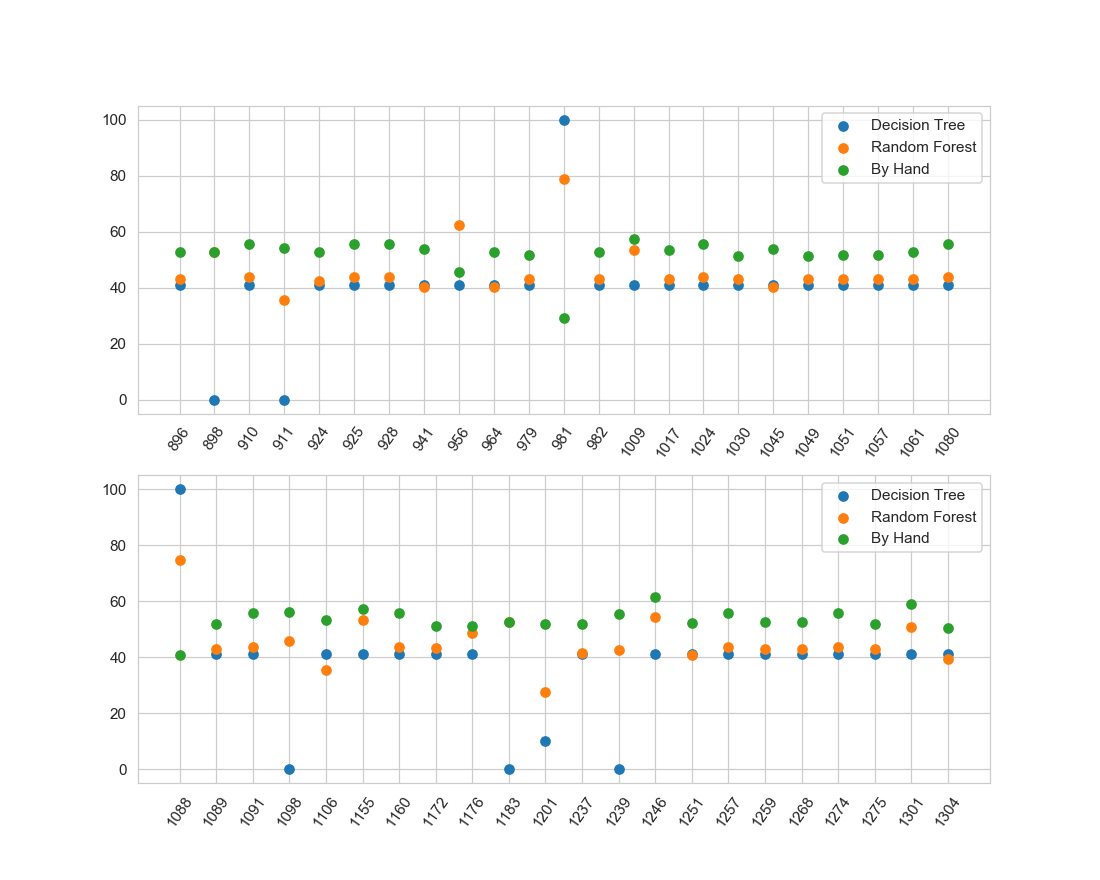

In [15]:
# lets look at the percentages that lead to the differences 
# using diff_index created above and the probabilities for dt and rf 

dt_survive, rf_survive, bh_survive = [] , [], []

for x in diff_index:
    dt_survive.append([test_data.loc[x,"PassengerId"], dt_percent[x,1]*100])
    rf_survive.append([test_data.loc[x,"PassengerId"], rf_percent[x,1]*100])
    bh_survive.append([bh_pcnt[x,0], bh_pcnt[x,1]])

dt_survive = np.array(dt_survive, dtype='object')
rf_survive = np.array(rf_survive, dtype='object')
bh_survive = np.array(bh_survive, dtype='object')


n = len(diff_index)//2
n2 = len(diff_index)
print(n, n2)
fig11 = plt.figure(figsize=(10,8))
ax = fig11.add_subplot(211)

plt.scatter(N[0:n], dt_survive[0:n,1], label='Decision Tree')
plt.scatter(N[0:n], rf_survive[0:n,1], label='Random Forest')
plt.scatter(N[0:n], bh_survive[0:n,1], label='By Hand')
plt.xticks(N[0:n], graph_array[0:n,0], rotation=55) 
plt.legend(loc='best')

ax = fig11.add_subplot(212)

plt.scatter(N[n+1:n2], dt_survive[n+1:n2,1], label='Decision Tree')
plt.scatter(N[n+1:n2], rf_survive[n+1:n2,1], label='Random Forest')
plt.scatter(N[n+1:n2], bh_survive[n+1:n2,1], label='By Hand')
plt.xticks(N[n+1:n2],graph_array[n+1:n2,0], rotation=55) 
# use the same passenger ID  
plt.legend(loc='best')
  
plt.show()

In [73]:

def fill_all_iterations(gender):
    # make a numpy array of all the possible combinations
    make_list = []
    
    # dt and rf trained for [pclass, age, sex, port] order 
    for pclass in range(1,4): # values start at 1 
        for port in range(3): # port range 0,1,2
            for age in range(101): # test first few ages 
                make_list.append([int(pclass), float(age), int(gender), int(port)])
    np_array = np.array(make_list)
    return np_array

male_set = fill_all_iterations(0)
female_set = fill_all_iterations(1)

female_dt_test = fit_dt.predict_proba(female_set) 
male_dt_test = fit_dt.predict_proba(male_set)

female_rf_test = fit_rf.predict_proba(female_set)
male_rf_test = fit_rf.predict_proba(male_set)

f_min_max_rf = [min(female_rf_test[:,1]), max(female_rf_test[:,1])]
f_min_max_index = [np.argmin(female_rf_test[:,1]), np.argmax(female_rf_test[:,1])]
f_prmtrs_rf = [female_set[f_min_max_index[0]], female_set[f_min_max_index[1]]  ]
m_min_max_rf = [min(male_rf_test[:,1]), max(male_rf_test[:,1])]
m_min_max_index = [np.argmin(male_rf_test[:,1]), np.argmax(male_rf_test[:,1])]
m_prmtrs_rf = [male_set[m_min_max_index[0]], male_set[m_min_max_index[1]]  ]

print("male:", m_min_max_rf, m_min_max_index)
print(m_prmtrs_rf )
print("female:", f_min_max_rf, f_min_max_index)
print(f_prmtrs_rf )

def split_class(array): 
    #split by classes and create array that can be 
    row1 = array[0:101,1]
    row2 = array[101:202,1]
    row3 = array[202:303,1]
    first = np.vstack((row1,row2,row3))
    
    row1 = array[303:404,1]
    row2 = array[404:505,1]
    row3 = array[505:606,1]
    second = np.vstack((row1,row2,row3))
    
    row1 = array[606:707,1]
    row2 = array[707:808,1]
    row3 = array[808:909,1]
    third = np.vstack((row1,row2,row3))
    return first, second, third

f_rf_first, f_rf_second, f_rf_third = split_class(female_rf_test)
m_rf_first, m_rf_second, m_rf_third = split_class(male_rf_test)



male: [0.10879706499298607, 0.8435756293057237] [664, 303]
[array([ 3., 58.,  0.,  0.]), array([2., 0., 0., 0.])]
female: [0.27433981631683674, 0.9612178773932427] [653, 134]
[array([ 3., 47.,  1.,  0.]), array([ 1., 33.,  1.,  1.])]


<IPython.core.display.Javascript object>


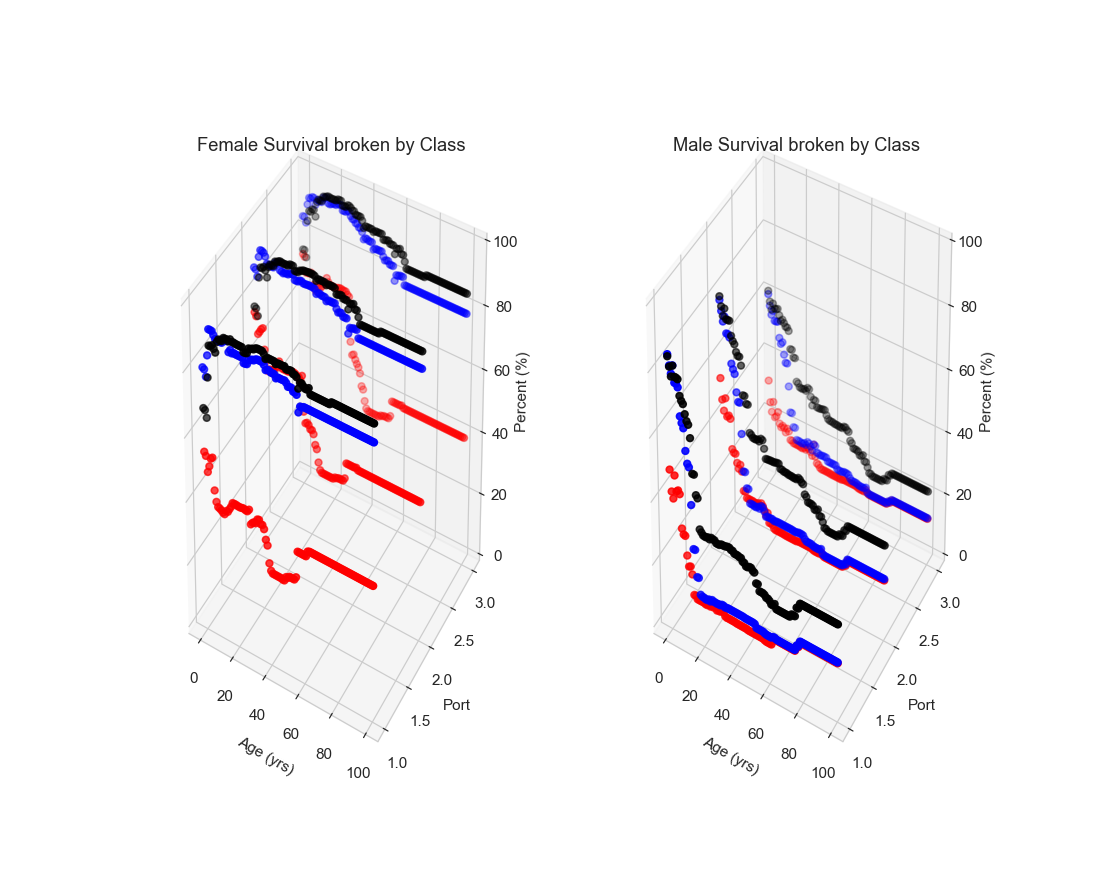

In [65]:
from mpl_toolkits import mplot3d
age_range = np.array(range(101))
class_range = np.array(range(1,4))
port_range = np.array(range(4))

fade = [1.0, 0.5, 0.1]

fig4 = plt.figure(figsize=(10,8))
ax4= fig4.add_subplot(121, projection='3d')

x, y = np.meshgrid(age_range , class_range)

#ax4.plot_surface(x, y, f_rf_first*100, cmap='Greens',label='First' )
#ax4.plot_surface(x, y, f_rf_second*100, cmap='Greys', label="Second" )
#ax4.plot_surface(x, y, f_rf_third*100, cmap='Purples' , label="Third")
ax4.scatter3D(x, y, f_rf_first*100, color='k', label='First' )
ax4.scatter3D(x, y, f_rf_second*100, color='b', label="Second" )
ax4.scatter3D(x, y, f_rf_third*100, color='r' , label="Third")

ax4.set_title('Female Survival broken by Class', fontsize = 12)
ax4.set_xlabel("Age (yrs)", fontsize = 10)
ax4.set_ylabel("Port", fontsize = 10);
#ax4.yticks(y, ["England","France","Ireland"])
ax4.set_zlabel("Percent (%)", fontsize = 10);
ax4.set_zlim(0,100)
#ax4.legend()
#ax4.view_init(elev=25., azim=120.)

ax4= fig4.add_subplot(122, projection='3d')
#ax4.plot_surface(x, y, m_rf_first*100, cmap='Greens',label='First' )
#ax4.plot_surface(x, y, m_rf_second*100, cmap='Greys', label="Second" )
#ax4.plot_surface(x, y, m_rf_third*100, cmap='Purples' , label="Third")
ax4.scatter3D(x, y, m_rf_first*100, color='k',label='First' )
ax4.scatter3D(x, y, m_rf_second*100, color='b', label="Second" )
ax4.scatter3D(x, y, m_rf_third*100, color='r' , label="Third")
ax4.set_zlim(0,100)
ax4.set_xlabel("Age (yrs)", fontsize = 10)
ax4.set_ylabel("Port", fontsize = 10);
ax4.set_zlabel("Percent (%)", fontsize = 10);
ax4.set_title('Male Survival broken by Class', fontsize = 12)

#fig4 = plt.figure(figsize=(10,10))
#ax4= fig4.add_subplot(313, projection='3d')

#ax4.scatter3D(x, y, f_rf_third*100, cmap='seismic' )

plt.show()

# Gamify the results 
## lets see if you can survive the sinking of the titanic! 

We will use that we have learned to make a small interactive game to calculate if your character will survive the titanic sinking! 


In [ ]:
# the game 
from ansimarkup import parse, ansiprint 
from random import seed
from random import random
import time 
seed(1)
#definitions  
def intro(): 
    # sets out some of the main parameters of the game, sex, age, class
    ansiprint("<b,g,>James:</b,g,>",\
        "<g>Hello, Welcome aboard the Titanic! My name is James, I am one of the crew members aboard this unsinkable ship.</g>",\
        "<g>May I take your name and see your ticket for the passenger list, please?</g>")
    time.sleep(7)
    name = str(input("Your name: "))
    name = name.strip()
    time.sleep(2)
    ansiprint(" ","<b,g,>James:</b,g,><g> Nice to meet you, %s. I will take your ticket now.</g>" %name)
    time.sleep(2)
    ansiprint("<b>You hand your ticket over to James for inspection.</b>", " ", sep="\n")
    time.sleep(2)
    check_ticket("Y", "James") 

    sex = str(input("What is your gender, Male or Female? ")).upper().strip()
    title, sex_bin, sex = sex_loop(sex)
    
    time.sleep(2)
    ansiprint("<b,g,>James:</b,g,><g> %s, Can you tell me your age?</g>"%title[1]) 
    time.sleep(0.5)
    age = int(input("What is your age: "))
    time.sleep(0.5)
    age = age_loop(age,"James")
    
    time.sleep(2)
    ansiprint("<b,g,>James:</b,g,><g> Its a beautiful day here today in.... Oh, wait where are we again?</g>",\
             "<g> I have been doing so much travelling I forgot which port this is!</g>", '  ', sep="\n")
    time.sleep(5)
    ansiprint('Your port:','1 = Southhampton, England', '2 = Cherbourg, France', '3 = Queenstown, Ireland', sep="\n")
    time.sleep(5)
    port = str(input()).strip()
    port_loop(port)
        
    ansiprint("<b,g,>James:</b,g,>", "<g>%s, Can you tell me which Class you booked?</g>" %title[1])
    print('Pick your class number:','1 = First class', '2 = Second class', '3 = Third Class', sep="\n")
    pclass = int(input())
    pclass = class_loop(pclass, "James")

    return name, age, sex_bin, sex, pclass, port, title

def len_adjust(string): 
    if len(string) >1: 
        string = string[0]
    return string

def check_ticket(ticket, chr_name):
    # "looks at the ticket, runs though iterations if players try to get around it"
    ticket_loop = True
    while ticket_loop: 
        ticket = len_adjust(ticket)
        if (ticket == "Y"): 
            ansiprint("<b>He rips the detachable strip down the side of your ticket and begins to read your details.</b>")
            time.sleep(2)
            ansiprint("<b,g,>%s:</b,g,> <g>Your ticket has become quite unreadable I'm afraid.</g>"%chr_name,\
                      "<g>I will need you to tell me some of your missing details.</g>")
            time.sleep(2)
            ticket_loop = False  
    return 

def sex_loop(sex): 
    sex_loop = True
    while sex_loop: 
        sex = len_adjust(sex)    
        if (sex != "M") and (sex != "F"): 
            dice_loop = True
            while dice_loop: 
                ansiprint("<b>Sorry, binary due to the fact that its 1912 and there is no non-binary data</b>",'  ', sep="\n")
                time.sleep(2)
                ansiprint("<b>would you like to roll the dice? </b>",'  ', sep="\n")
                time.sleep(2)
                dice = str(input("Y for random assignment, N to choose assignment: ")).strip().upper()
                dice = len_adjust(dice)
                if dice == "Y":
                    dice_loop = False
                    ansiprint("<b>Rolling the dice for random assignment</b>",'  ', sep="\n")
                    time.sleep(2)
                    ran = random()
                    if ran<= 0.5: 
                        sex= 'M'
                    else:
                        sex= "F"
                elif dice == "N": 
                    sex = str(input("What is your gender, Male or Female? ")).upper().strip()
                    sex = len_adjust(sex)
                    if (sex == "M") or (sex =="F"): dice_loop = False
                else: 
                    dice_loop = True
    
        if sex == "M": 
            sex_bin = 0
            title = ["Mr.", "Sir"]
            assign = "Male"
            sex_loop = False
        else: 
            sex_bin = 1 
            title = ["Ms.", "Miss"]
            assign = "Female"
            sex_loop= False
    time.sleep(2)
    print(" ","You have %s as your gender" %assign,'  ', sep="\n")
    return title, sex_bin, sex

def age_loop(age, chr_name): 
    # determines the age of the character if players try and use values not possible
    age_loop = True
    three_attempts = 0
    while age_loop: 
        if age <0: # negative numbers
            age = abs(age)
            ansiprint("<b,g,>%s:</b,g,><g> A negative age?</g>"%chr_name, "<g>I'm sure you meant %i </g>"%age,'  ', sep="\n")
            age_loop = False
        elif (81 <= age < 122): # pretty old but not unheard of
            ansiprint("<b,g,>%s:</b,g,><g> Thats getting up there. My Granny's that age as well.</g>"%chr_name,'  ', sep="\n")  
            age_loop = False
        elif age >= 122: # no one alive is that old
            three_attempts += 1
            if three_attempts <3: 
                ansiprint("<b,g,>%s:</b,g,> <g>Ha Ha. Sometimes we all feel that old, but what is your"\
                      " actual age now? </g>" %chr_name,'  ', sep="\n")
                age = int(input('new age: '))
            else: 
                age = int(random()*100)
                ansiprint("<b,g,>%s:</b,g,> <g>You're quite the trouble maker arn't ya?</g>"%chr_name, \
                          "<g>You look about %i to me so thats what's going in the passenger log.</g>"%age)
                age_loop = False
        else: # age between 0 and 100
            ansiprint(" ","<b,g,>%s:</b,g,> <g>Thank you!</g>" %chr_name, " ",sep="\n")
            age_loop = False

    return age

def class_loop(pclass, chr_name): 
    #determines the class of the person, and if they have been bad (determined by trouble) they are randomly 
    # assigned to a class and if they have been good they get promoted a class
    class_loop = True
    t_loop=0
    while class_loop:
        # trouble makers
        if ((pclass > 3) or (pclass < 1)) and (t_loop <=2): # low level
            t_loop +=1
            ansiprint("<b,g,>%s:</b,g,> <g>Sorry, what class what that?</g>" %chr_name,'  ', sep="\n")
            pclass = int(input("Choose class: "))
        elif ((pclass > 3) or (pclass < 1)) and (t_loop ==3): # last go around 
            ansiprint("<b,g,>%s:</b,g,> <g>Your holding up the line now</g>" %chr_name)
            ansiprint("<b>%s walks over to a bucket of keys, clearly meant for last minute ticket purchasers"\
                      " and grabs one at random.</b>" % chr_name,'  ', sep="\n")
            ansiprint("<b,g,>%s:</b,g,> <g>This is the key to your randomly assigned room."\
                      " You need to move out of the way so I can help the other passengers!</g>"%chr_name,'  ', sep="\n")
            ran = random()
            if ran < 2/3: 
                pclass = 2
            elif  2/3 <= ran < 5/6: 
                pclass = 3
            else: 
                pclass = 1 
            ansiprint("<b> You look at your newly assigned key which is labeled with '%i st Class' </b>"%pclass,'  ', sep="\n")
            class_loop = False
        # not trouble makers 
        elif (1 <= pclass <=3):
            ansiprint("<b,g,>%s:</b,g,> <g>Thank you for your cooperation today! It has been"\
                      " my pleasure to help you.</g>"%chr_name,'  ', sep="\n")
            class_loop = False 

    return pclass

def port_loop(port):
    port_loop = True 
    port_try = 0
    ports = ["Southhampton, England", "Cherbourg, France", "Queenstown, Ireland"]
    while port_loop: 
        if ((port > "3") or (port < "1")) and (port_try <3): 
            port_try +=1
            ansiprint("<b,g,>James:</b,g,><g> I must have heard that wrong. What port did you say?<g>",'  ', sep="\n")
            time.sleep(2)
            port = str(input()).strip()
        elif ((port > "3") or (port < "1")) and (port_try == 3): 
            ran = random()
            port_loop = False
            if ran < 0.333333: 
                port = 1
            elif 0.333333 <= ran < 0.666666: 
                port = 2
            else: 
                port = 3 
            ansiprint("<b,g,>James:</b,g,><g> Oh yes, I remember now! We are in %s. Goodness, how forgetful of me!<g>"%ports[int(port)-1],\
                     '  ', sep="\n")
            time.sleep(2)
        else: # 1<= port <=3
            ansiprint("<b,g,>James:</b,g,><g> Of course, %s! How could I forget!?</g> "%ports[int(port)-1],'  ', sep="\n")
            time.sleep(2)
            port_loop = False
    return port

# gameify test 
start = True
the_game = True 
while the_game: 
    if start: 
        ansiprint("<b>You are a passenger on the titanic. Your goal is to survive the sinking!</b>",\
          "<b>You must choose your demographics carefully to win the game.</b>",\
          "<b>There are 4 demographics: age, sex (binary), class and the port of which you got on the titanic.</b>",\
                  '  ', sep="\n")
        time.sleep(9.5)
        ansiprint("<b>Good Luck!</b>", '  ', sep="\n")
        time.sleep(1)
    
    name, age, sex_bin, sex, pclass, port, title = intro()
    
    # random forest 
    choice_array = np.array([pclass, age, sex_bin, port])
    choice_array = choice_array.reshape(1, -1)
    live_or_die = fit_rf.predict(choice_array)
    live_or_die_pcnt = fit_rf.predict_proba(choice_array)
    
    ansiprint(" ",'<b>Calculating result for:</b>', sep="\n")
    time.sleep(2)
    print("Name: "+name,"Age: "+str(age),"Gender: "+str(sex),"Class: "+str(pclass),"Port: "+str(port)," ", sep="\n")
    time.sleep(5)
    ansiprint('<b>Chance of Survival:</b>', live_or_die_pcnt[0][1]*100)
    time.sleep(3)
    ansiprint("<b>...... and the result is........</b>", " ",sep="\n")
    time.sleep(5)
    if live_or_die == 0: 
        ansiprint("<b>You lose! Better luck next time.</b>")
        play_again = str(input('Try again? (Y/N)')).upper()
    else: 
        ansiprint("<b>You win! You have survived the Titanic sinking.</b>",\
        " ", sep="\n")   
        play_again = str(input('Play again? (Y/N)')).upper()
    
    start = False
    if play_again == 'N': 
        the_game = False 
        ansiprint("<b>Game Over</b>")
    